# Телеком — задача дипломного проекта

На основании данных сотового оператора (данные о клиентах, информация о тарифах и договорах) заказчику - сотовому оператору - требуется научиться прогнозировать отток клиентов. В случае прогноза ухода клиент будет мотивирован остаться предложенными промокодами и специальными условиями.

### Услуги оператора

Основные:

1. Телефонную связь. Может производиться подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение двух типов: через телефонную линию (DSL) или оптоволоконный кабель (Fiber optic).  

Дополнительные:

- Интернет-безопасность: антивирус и блокировка небезопасных сайтов;
- Техническая поддержка;
- Облачное хранилище;
- Стриминговые ТВ и каталог фильмов.

### Условия оператора 

    Расчетный период:
        * Оплата 1 раз в месяц;
        * Заключение договора на 1-2 года.

    Различные способы расчета

    Возможность получения электронного чека


### Описание данных

Таблицы, полученные из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Актуальная дата 1 февраля 2020.

## Загрузка библиотек

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from datetime import datetime

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

## Загрузка данных

In [4]:
contract = pd.read_csv('contract.csv')
display(contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [5]:
print(contract.isna().sum())
print()
print(contract.duplicated().sum())

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

0


In [6]:
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Так как в методе describe не появился столбец TotalCharges, значит там не только числовые аргументы, проверим

In [7]:
contract.dtypes

customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object

In [8]:
contract['TotalCharges'].unique()

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [9]:
contract['TotalCharges'].isna().sum()

0

In [10]:
display(contract[contract['TotalCharges']==''])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


In [11]:
display(contract[contract['TotalCharges']==' '])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [12]:
print(contract[contract['TotalCharges']==' ']['customerID'].count())

11


Нашлись 11 строк, в которых TotalCharges - это пробел, каждый из них начал договор в актуальную дату 2020-02-01, то есть они еще ничего не оплачивали, даже первый месяц не прошел, следовательно заменяю, в них значение TotalCharges на 0

In [13]:
contract.loc[contract['TotalCharges']==' ', 'TotalCharges'] = 0
display(contract[contract['TotalCharges']==' '])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


In [14]:
display(contract[contract['TotalCharges']==0])

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,0


In [15]:
internet = pd.read_csv('internet.csv')
display(internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [16]:
print(internet.isna().sum())
print()
print(internet.duplicated().sum())

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

0


In [17]:
print(internet.dtypes)

customerID          object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
dtype: object


In [18]:
personal = pd.read_csv('personal.csv')
display(personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [19]:
print(personal.isna().sum())
print()
print(personal.duplicated().sum())

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

0


In [20]:
print(personal.dtypes)

customerID       object
gender           object
SeniorCitizen     int64
Partner          object
Dependents       object
dtype: object


In [21]:
phone = pd.read_csv('phone.csv')
display(phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [22]:
print(phone.isna().sum())
print()
print(phone.duplicated().sum())

customerID       0
MultipleLines    0
dtype: int64

0


In [23]:
print(phone.dtypes)

customerID       object
MultipleLines    object
dtype: object


In [24]:
print('contract',contract.columns)
print()
print('internet',internet.columns)
print()
print('personal',personal.columns)
print()
print('phone',phone.columns)

contract Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

internet Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

personal Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

phone Index(['customerID', 'MultipleLines'], dtype='object')


**contract**

    'customerID' - пользовательский ID
    'BeginDate' - дата начала
    'EndDate' - дата окончания 
    'Type' - тип оплаты (раз в месяц, раз в год, раз в 2 года)
    'PaperlessBilling' - электронный платежный документ 
    'PaymentMethod' - способ оплаты
    'MonthlyCharges' - ежемесячные платежи
    'TotalCharges' - общая стоимость

**internet**

    'customerID' - пользовательский ID
    'InternetService' - интернет-сервис
    'OnlineSecurity' - блокировка небезопасных сайтов
    'OnlineBackup' - облачное хранилище
    'DeviceProtection' - антивирус
    'TechSupport' - техническая поддержка
    'StreamingTV' - стриминговое телевидение
    'StreamingMovies' - каталог фильмов
    
**personal**

    'customerID' - пользовательский ID
    'gender' - пол
    'SeniorCitizen'- пенсионер
    'Partner' - партнер (коллега, сотрудник)
    'Dependents' - зависящий

**phone**

    'customerID' - пользовательский ID
    'MultipleLines' - несколько линий

## Объединение данных

In [25]:
data = personal.merge(contract, how='left', on='customerID')
display(data)

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,Female,0,Yes,Yes,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,Female,0,Yes,Yes,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,Male,1,Yes,No,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


In [26]:
data = data.merge(internet, on='customerID', how='left')
display(data)

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,DSL,Yes,No,Yes,Yes,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,Fiber optic,No,Yes,Yes,No,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,No,No,No,No,No
7041,8361-LTMKD,Male,1,Yes,No,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,Fiber optic,No,No,No,No,No,No


In [27]:
data = data.merge(phone, on='customerID', how='left')
display(data)

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,Male,1,Yes,No,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,Fiber optic,No,No,No,No,No,No,Yes


## Предобработка данных

In [28]:
print('InternetService', data['InternetService'].unique())
print('OnlineSecurity', data['OnlineSecurity'].unique())
print('OnlineBackup', data['OnlineBackup'].unique())
print('DeviceProtection', data['DeviceProtection'].unique())
print('TechSupport', data['TechSupport'].unique())
print('StreamingTV', data['StreamingTV'].unique())
print('StreamingMovies', data['StreamingMovies'].unique())
print('MultipleLines', data['MultipleLines'].unique())

InternetService ['DSL' 'Fiber optic' nan]
OnlineSecurity ['No' 'Yes' nan]
OnlineBackup ['Yes' 'No' nan]
DeviceProtection ['No' 'Yes' nan]
TechSupport ['No' 'Yes' nan]
StreamingTV ['No' 'Yes' nan]
StreamingMovies ['No' 'Yes' nan]
MultipleLines [nan 'No' 'Yes']


In [29]:
data.isna().sum()

customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

In [30]:
data['InternetService'] = data['InternetService'].fillna('not use internet')
data['OnlineSecurity'] = data['OnlineSecurity'].fillna('not use internet')
data['OnlineBackup'] = data['OnlineBackup'].fillna('not use internet')
data['OnlineSecurity'] = data['OnlineSecurity'].fillna('not use internet')
data['DeviceProtection'] = data['DeviceProtection'].fillna('not use internet')
data['TechSupport'] = data['TechSupport'].fillna('not use internet')
data['StreamingTV'] = data['StreamingTV'].fillna('not use internet')
data['StreamingMovies'] = data['StreamingMovies'].fillna('not use internet')
data['MultipleLines'] = data['MultipleLines'].fillna('not use phone')

display(data)

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,not use phone
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,not use phone
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,No,No,No,No,No,not use phone
7041,8361-LTMKD,Male,1,Yes,No,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,Fiber optic,No,No,No,No,No,No,Yes


In [31]:
data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

In [32]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
MultipleLines        object
dtype: object

In [33]:
data['TotalCharges'] = data['TotalCharges'].astype('float')

In [34]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
MultipleLines        object
dtype: object

## Исследовательский анализ данных

In [35]:
print(data.describe())

       SeniorCitizen  MonthlyCharges  TotalCharges
count    7043.000000     7043.000000   7043.000000
mean        0.162147       64.761692   2279.734304
std         0.368612       30.090047   2266.794470
min         0.000000       18.250000      0.000000
25%         0.000000       35.500000    398.550000
50%         0.000000       70.350000   1394.550000
75%         0.000000       89.850000   3786.600000
max         1.000000      118.750000   8684.800000


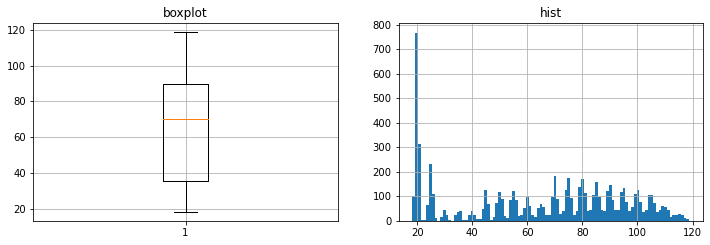

In [36]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.grid()
plt.boxplot(data['MonthlyCharges'])
plt.title('boxplot')

plt.subplot(2, 2, 2)
plt.grid()
plt.hist(data['MonthlyCharges'], bins=100)
plt.title('hist')

plt.show()

На графике ящика с усами выбросов как таковых нет, на гистограмме видно, что большинство клиентов имеют MonthlyCharges = 19-20

/Users/annatopilskaya/anaconda3/lib/python3.9/site-packages/numpy/lib/stride_tricks.py:536: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/Users/annatopilskaya/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


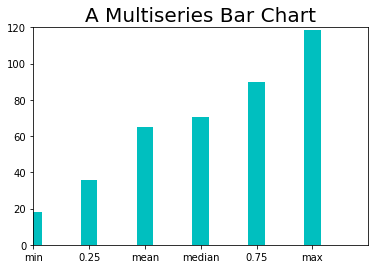

In [37]:
data_min = data['MonthlyCharges'].min()
data_25 = data['MonthlyCharges'].quantile(0.25),
data_mean = data['MonthlyCharges'].mean(),
data_median = data['MonthlyCharges'].median(),
data_75 = data['MonthlyCharges'].quantile(0.75),
data_max = data['MonthlyCharges'].max()

index = np.arange(6)
x = [data_min, data_25, data_mean, data_median, data_75, data_max]
bw = 0.3
plt.title('A Multiseries Bar Chart', fontsize=20)
plt.axis([0,6,0,120])
plt.bar(index, x, bw, color='c')
plt.xticks(index, ['min','0.25','mean','median','0.75', 'max'])
plt.show()

In [38]:
# выделяю две группы сохранившихся и ушедших клиентов:
data_left = data[data['EndDate']!='No'] # ушедшие клиенты
data_keep = data[data['EndDate']=='No'] # сохранившиеся

print(data_left.shape)
print(data_keep.shape)

(1869, 20)
(5174, 20)


In [39]:
display(data_left.head())

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,Female,0,No,No,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.50,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
8,7892-POOKP,Female,0,Yes,No,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
13,0280-XJGEX,Male,0,No,No,2015-09-01,2019-10-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes


In [40]:
display(data_keep.head())

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,not use phone
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,not use phone
6,1452-KIOVK,Male,0,No,Yes,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,Female,0,No,No,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.90,DSL,Yes,No,No,No,No,No,not use phone


In [41]:
print(data_keep.describe())

       SeniorCitizen  MonthlyCharges  TotalCharges
count    5174.000000     5174.000000   5174.000000
mean        0.128721       61.265124   2549.911442
std         0.334923       31.092648   2329.954215
min         0.000000       18.250000      0.000000
25%         0.000000       25.100000    572.900000
50%         0.000000       64.425000   1679.525000
75%         0.000000       88.400000   4262.850000
max         1.000000      118.750000   8672.450000


In [42]:
print(data_left.describe())

       SeniorCitizen  MonthlyCharges  TotalCharges
count    1869.000000     1869.000000   1869.000000
mean        0.254682       74.441332   1531.796094
std         0.435799       24.666053   1890.822994
min         0.000000       18.850000     18.850000
25%         0.000000       56.150000    134.500000
50%         0.000000       79.650000    703.550000
75%         1.000000       94.200000   2331.300000
max         1.000000      118.350000   8684.800000


In [43]:
print('MonthlyCharges сохранившиеся клиенты')
print()
print('Минимальное значение',data_keep['MonthlyCharges'].min())
print('25-ый квантиль',data_keep['MonthlyCharges'].quantile(0.25))
print('Медиана',data_keep['MonthlyCharges'].median())
print('Среднее значение',data_keep['MonthlyCharges'].mean())
print('75-ый квантиль',data_keep['MonthlyCharges'].quantile(0.75))
print('Максимальное значение',data_keep['MonthlyCharges'].max())

MonthlyCharges сохранившиеся клиенты

Минимальное значение 18.25
25-ый квантиль 25.1
Медиана 64.42500000000001
Среднее значение 61.2651236953999
75-ый квантиль 88.4
Максимальное значение 118.75


In [44]:
print('MonthlyCharges ушедшие клиенты')
print()
print('Минимальное значение',data_left['MonthlyCharges'].min())
print('25-ый квантиль',data_left['MonthlyCharges'].quantile(0.25))
print('Медиана',data_left['MonthlyCharges'].median())
print('Среднее значение',data_left['MonthlyCharges'].mean())
print('75-ый квантиль',data_left['MonthlyCharges'].quantile(0.75))
print('Максимальное значение',data_left['MonthlyCharges'].max())

MonthlyCharges ушедшие клиенты

Минимальное значение 18.85
25-ый квантиль 56.15
Медиана 79.65
Среднее значение 74.4413322632423
75-ый квантиль 94.2
Максимальное значение 118.35


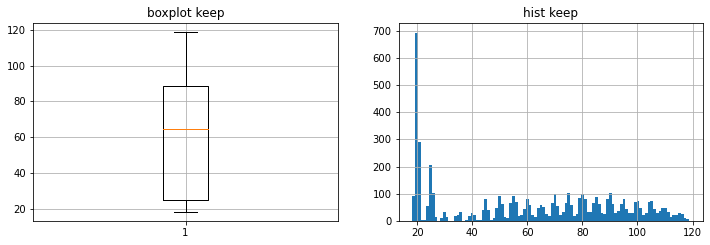

In [45]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.grid()
plt.boxplot(data_keep['MonthlyCharges'])
plt.title('boxplot keep')

plt.subplot(2, 2, 2)
plt.grid()
plt.hist(data_keep['MonthlyCharges'], bins=100)
plt.title('hist keep')

plt.show()

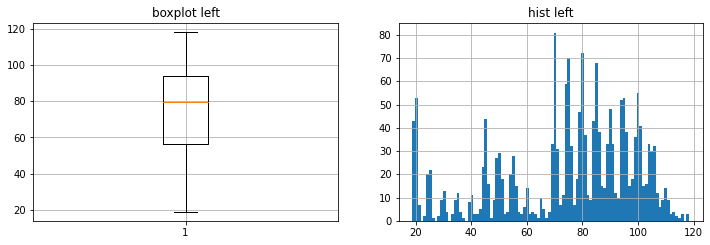

In [46]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.grid()
plt.boxplot(data_left['MonthlyCharges'])
plt.title('boxplot left')

plt.subplot(2, 2, 2)
plt.grid()
plt.hist(data_left['MonthlyCharges'], bins=100)
plt.title('hist left')

plt.show()

/Users/annatopilskaya/anaconda3/lib/python3.9/site-packages/numpy/lib/stride_tricks.py:536: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = [np.array(_m, copy=False, subok=subok) for _m in args]
/Users/annatopilskaya/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


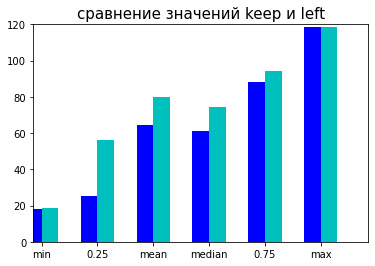

In [47]:
left_min = data_left['MonthlyCharges'].min()
left_25 = data_left['MonthlyCharges'].quantile(0.25),
left_median = data_left['MonthlyCharges'].median(),
left_mean = data_left['MonthlyCharges'].mean(),
left_75 = data_left['MonthlyCharges'].quantile(0.75),
left_max = data_left['MonthlyCharges'].max()

keep_min = data_keep['MonthlyCharges'].min()
keep_25 = data_keep['MonthlyCharges'].quantile(0.25),
keep_median = data_keep['MonthlyCharges'].median(),
keep_mean = data_keep['MonthlyCharges'].mean(),
keep_75 = data_keep['MonthlyCharges'].quantile(0.75),
keep_max = data_keep['MonthlyCharges'].max()

index = np.arange(6)
left = [left_min, left_25, left_median, left_mean, left_75, left_max]
keep = [keep_min, keep_25, keep_median, keep_mean, keep_75, keep_max]
bw = 0.3
plt.title('сравнение значений keep и left', fontsize=15)
plt.axis([0,6,0,120])
plt.bar(index, keep, bw, color='b')
plt.bar(index+bw, left, bw, color='c')
plt.xticks(index+0.5*bw, ['min','0.25','mean','median','0.75', 'max'])
plt.show()

У сохранившихся клиентов значения в каждом столбце меньше, чем у ушедших клиентов. То есть ушедшие клиенты везде платили больше, поэтому логичен их уход.

**ГРУППА СОХРАНИВШИХСЯ КЛИЕНТОВ**

In [48]:
data_keep_phone = data_keep[data_keep['MultipleLines']!='not use phone']
data_keep_not_phone = data_keep[data_keep['MultipleLines']=='not use phone']

data_keep_internet = data_keep[data_keep['InternetService']!='not use internet']
data_keep_not_internet = data_keep[data_keep['InternetService']=='not use internet']

print(data_keep_phone.shape)
print(data_keep_not_phone.shape)
print(data_keep_internet.shape)
print(data_keep_not_internet.shape)

(4662, 20)
(512, 20)
(3761, 20)
(1413, 20)


ТЕЛЕФОН

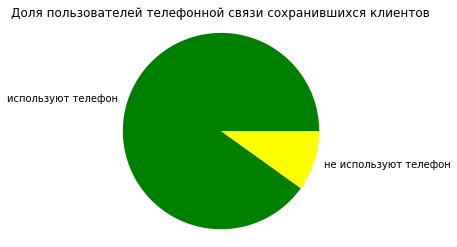

In [49]:
labels = ['используют телефон','не используют телефон']
values = [data_keep_phone['customerID'].count(),data_keep_not_phone['customerID'].count()]
colors = ['green','yellow']
plt.pie(values,labels=labels,colors=colors)
plt.axis('equal')
plt.title('Доля пользователей телефонной связи сохранившихся клиентов')
plt.show()

In [50]:
print('Доля пользователей телефонной связи сохранившихся клиентов в процентах')
print(data_keep_phone['customerID'].count() / data_keep['customerID'].count() * 100)
print()
print('Доля пользователей, не использующие телефонную связь, сохранившихся клиентов в процентах')
print(100 - data_keep_phone['customerID'].count() / data_keep['customerID'].count() * 100)

Доля пользователей телефонной связи сохранившихся клиентов в процентах
90.10436799381523

Доля пользователей, не использующие телефонную связь, сохранившихся клиентов в процентах
9.89563200618477


ИНТЕРНЕТ

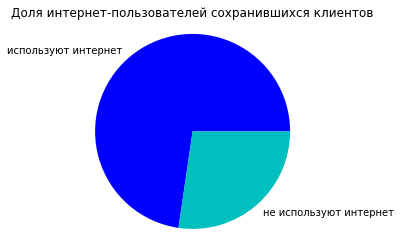

In [51]:
labels = ['используют интернет','не используют интернет']
values = [data_keep_internet['customerID'].count(),data_keep_not_internet['customerID'].count()]
colors = ['b','c']
plt.pie(values,labels=labels,colors=colors)
plt.axis('equal')
plt.title('Доля интернет-пользователей сохранившихся клиентов')
plt.show()

In [52]:
print('Доля интернет-пользователей сохранившихся клиентов в процентах')
print(data_keep_internet['customerID'].count() / data_keep['customerID'].count() * 100)
print()
print('Доля пользователей, не использующих интернет, сохранившихся клиентов в процентах')
print(100 - data_keep_internet['customerID'].count() / data_keep['customerID'].count() * 100)

Доля интернет-пользователей сохранившихся клиентов в процентах
72.69037495168148

Доля пользователей, не использующих интернет, сохранившихся клиентов в процентах
27.309625048318523


**ГРУППА УШЕДШИХ КЛИЕНТОВ**

In [53]:
data_left_phone = data_left[data_left['MultipleLines']!='not use phone']
data_left_not_phone = data_left[data_left['MultipleLines']=='not use phone']

data_left_internet = data_left[data_left['InternetService']!='not use internet']
data_left_not_internet = data_left[data_left['InternetService']=='not use internet']

print(data_left_phone.shape)
print(data_left_not_phone.shape)
print(data_left_internet.shape)
print(data_left_not_internet.shape)

(1699, 20)
(170, 20)
(1756, 20)
(113, 20)


ТЕЛЕФОН

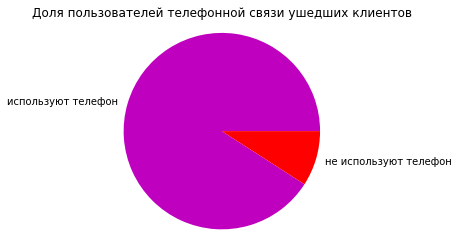

In [54]:
labels = ['используют телефон','не используют телефон']
values = [data_left_phone['customerID'].count(),data_left_not_phone['customerID'].count()]
colors = ['m','r']
plt.pie(values,labels=labels,colors=colors)
plt.axis('equal')
plt.title('Доля пользователей телефонной связи ушедших клиентов')
plt.show()

In [55]:
print('Доля пользователей телефонной связи ушедших клиентов в процентах')
print(data_left_phone['customerID'].count() / data_left['customerID'].count() * 100)
print()
print('Доля пользователей, не использующие телефонную связь, ушедших клиентов в процентах')
print(100 - data_left_phone['customerID'].count() / data_left['customerID'].count() * 100)

Доля пользователей телефонной связи ушедших клиентов в процентах
90.90422685928304

Доля пользователей, не использующие телефонную связь, ушедших клиентов в процентах
9.095773140716958


ИНТЕРНЕТ

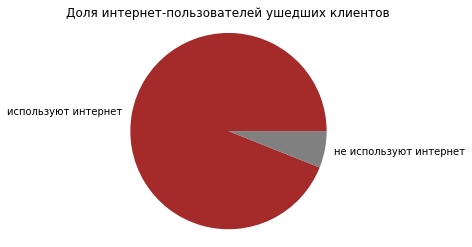

In [56]:
labels = ['используют интернет','не используют интернет']
values = [data_left_internet['customerID'].count(),data_left_not_internet['customerID'].count()]
colors = ['brown','gray']
plt.pie(values,labels=labels,colors=colors)
plt.axis('equal')
plt.title('Доля интернет-пользователей ушедших клиентов')
plt.show()

In [57]:
print('Доля интернет-пользователей ушедших клиентов в процентах')
print(data_left_internet['customerID'].count() / data_left['customerID'].count() * 100)
print()
print('Доля пользователей, не использующих интернет, ушедших клиентов в процентах')
print(100 - data_left_internet['customerID'].count() / data_left['customerID'].count() * 100)

Доля интернет-пользователей ушедших клиентов в процентах
93.95398608881756

Доля пользователей, не использующих интернет, ушедших клиентов в процентах
6.046013911182442


## Предобработка выборки для обучения

In [58]:
display(data)

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,not use phone
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,not use phone
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,No,No,No,No,No,not use phone
7041,8361-LTMKD,Male,1,Yes,No,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60,Fiber optic,No,No,No,No,No,No,Yes


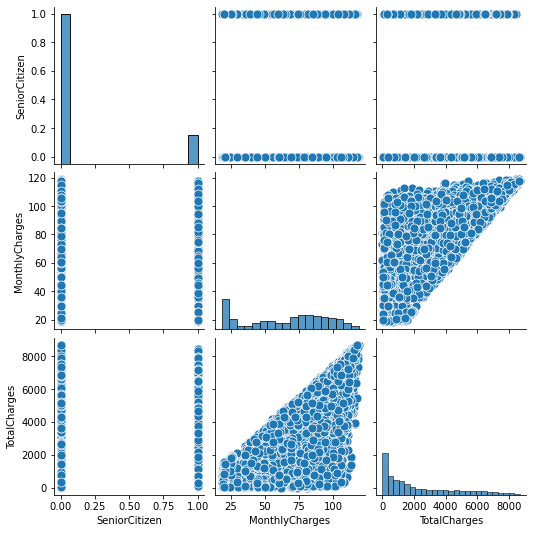

In [59]:
sns.pairplot(data, kind="scatter", plot_kws=dict(s=80, edgecolor="white"))
plt.show()

In [60]:
print(data.corr())

                SeniorCitizen  MonthlyCharges  TotalCharges
SeniorCitizen        1.000000        0.220173      0.103006
MonthlyCharges       0.220173        1.000000      0.651174
TotalCharges         0.103006        0.651174      1.000000


**Вывод**

И по диаграмме зависимости, и по таблице корреляции вижу только зависимость между MonthlyCharges и TotalCharges. Это логичная зависимость: чем больше платим в месяц, тем больше платим всего. И наоборот.

In [61]:
df = data

In [62]:
def funcion_partner(row):
    if row['Partner'] == 'Yes':
        return 1
    else:
        return 0
    
def funcion_dependents(row):
    if row['Dependents'] == 'Yes':
        return 1
    else:
        return 0
    
def funcion_paper(row):
    if row['PaperlessBilling'] == 'Yes':
        return 1
    else:
        return 0

def funcion_onlinesec(row):
    if row['OnlineSecurity'] == 'Yes':
        return 1
    elif row['OnlineSecurity'] == 'No':
        return 0
    else:
        return -1

def funcion_onlineback(row):
    if row['OnlineBackup'] == 'Yes':
        return 1
    elif row['OnlineBackup'] == 'No':
        return 0
    else:
        return -1
    
def funcion_devprot(row):
    if row['DeviceProtection'] == 'Yes':
        return 1
    elif row['DeviceProtection'] == 'No':
        return 0
    else:
        return -1
    
def funcion_techsup(row):
    if row['TechSupport'] == 'Yes':
        return 1
    elif row['TechSupport'] == 'No':
        return 0
    else:
        return -1
    
def funcion_streamtv(row):
    if row['StreamingTV'] == 'Yes':
        return 1
    elif row['StreamingTV'] == 'No':
        return 0
    else:
        return -1
    
def funcion_streammovies(row):
    if row['StreamingMovies'] == 'Yes':
        return 1
    elif row['StreamingMovies'] == 'No':
        return 0
    else:
        return -1
    
def funcion_multiplelines(row):
    if row['MultipleLines'] == 'Yes':
        return 1
    elif row['MultipleLines'] == 'No':
        return 0
    else:
        return -1

df['Partner_num'] = df.apply(funcion_partner, axis=1)
df['Dependents_num'] = df.apply(funcion_dependents, axis=1)
df['PaperlessBilling_num'] = df.apply(funcion_paper, axis=1)
df['OnlineSecurity_num'] = df.apply(funcion_onlinesec, axis=1)
df['OnlineBackup_num'] = df.apply(funcion_onlineback, axis=1)
df['DeviceProtection_num'] = df.apply(funcion_devprot, axis=1)
df['TechSupport_num'] = df.apply(funcion_techsup, axis=1)
df['StreamingTV_num'] = df.apply(funcion_streamtv, axis=1)
df['StreamingMovies'] = df.apply(funcion_streammovies, axis=1)
df['MultipleLines_num'] = df.apply(funcion_multiplelines, axis=1)
df = df.drop(['Partner', 
                  'Dependents', 
                  'PaperlessBilling', 
                  'OnlineSecurity', 
                  'OnlineBackup', 
                  'DeviceProtection',
                  'TechSupport',
                  'StreamingTV',
                  'StreamingMovies',
                  'MultipleLines'], axis=1)
display(df)

,customerID,gender,SeniorCitizen,BeginDate,EndDate,Type,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,Partner_num,Dependents_num,PaperlessBilling_num,OnlineSecurity_num,OnlineBackup_num,DeviceProtection_num,TechSupport_num,StreamingTV_num,MultipleLines_num
0,7590-VHVEG,Female,0,2020-01-01,No,Month-to-month,Electronic check,29.85,29.85,DSL,1,0,1,0,1,0,0,0,-1
1,5575-GNVDE,Male,0,2017-04-01,No,One year,Mailed check,56.95,1889.50,DSL,0,0,0,1,0,1,0,0,0
2,3668-QPYBK,Male,0,2019-10-01,2019-12-01 00:00:00,Month-to-month,Mailed check,53.85,108.15,DSL,0,0,1,1,1,0,0,0,0
3,7795-CFOCW,Male,0,2016-05-01,No,One year,Bank transfer (automatic),42.30,1840.75,DSL,0,0,0,1,0,1,1,0,-1
4,9237-HQITU,Female,0,2019-09-01,2019-11-01 00:00:00,Month-to-month,Electronic check,70.70,151.65,Fiber optic,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,2018-02-01,No,One year,Mailed check,84.80,1990.50,DSL,1,1,1,1,0,1,1,1,1
7039,2234-XADUH,Female,0,2014-02-01,No,One year,Credit card (automatic),103.20,7362.90,Fiber optic,1,1,1,0,1,1,0,1,1
7040,4801-JZAZL,Female,0,2019-03-01,No,Month-to-month,Electronic check,29.60,346.45,DSL,1,1,1,1,0,0,0,0,-1
7041,8361-LTMKD,Male,1,2019-07-01,2019-11-01 00:00:00,Month-to-month,Mailed check,74.40,306.60,Fiber optic,1,0,1,0,0,0,0,0,1


In [63]:
#  посчитаю продолжительность жизни клиента и добавлю два признака: продолжительность и отток (целевой)
def target(row):
    if row['EndDate'] == 'No':
        return 0
    else:
        return 1

df['Target'] = df.apply(target, axis=1)
display(df)

,customerID,gender,SeniorCitizen,BeginDate,EndDate,Type,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,Partner_num,Dependents_num,PaperlessBilling_num,OnlineSecurity_num,OnlineBackup_num,DeviceProtection_num,TechSupport_num,StreamingTV_num,MultipleLines_num,Target
0,7590-VHVEG,Female,0,2020-01-01,No,Month-to-month,Electronic check,29.85,29.85,DSL,1,0,1,0,1,0,0,0,-1,0
1,5575-GNVDE,Male,0,2017-04-01,No,One year,Mailed check,56.95,1889.50,DSL,0,0,0,1,0,1,0,0,0,0
2,3668-QPYBK,Male,0,2019-10-01,2019-12-01 00:00:00,Month-to-month,Mailed check,53.85,108.15,DSL,0,0,1,1,1,0,0,0,0,1
3,7795-CFOCW,Male,0,2016-05-01,No,One year,Bank transfer (automatic),42.30,1840.75,DSL,0,0,0,1,0,1,1,0,-1,0
4,9237-HQITU,Female,0,2019-09-01,2019-11-01 00:00:00,Month-to-month,Electronic check,70.70,151.65,Fiber optic,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,2018-02-01,No,One year,Mailed check,84.80,1990.50,DSL,1,1,1,1,0,1,1,1,1,0
7039,2234-XADUH,Female,0,2014-02-01,No,One year,Credit card (automatic),103.20,7362.90,Fiber optic,1,1,1,0,1,1,0,1,1,0
7040,4801-JZAZL,Female,0,2019-03-01,No,Month-to-month,Electronic check,29.60,346.45,DSL,1,1,1,1,0,0,0,0,-1,0
7041,8361-LTMKD,Male,1,2019-07-01,2019-11-01 00:00:00,Month-to-month,Mailed check,74.40,306.60,Fiber optic,1,0,1,0,0,0,0,0,1,1


In [64]:
df.loc[df['EndDate']=='No', 'EndDate'] = '2020-02-01 00:00:00'
display(df)

,customerID,gender,SeniorCitizen,BeginDate,EndDate,Type,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,Partner_num,Dependents_num,PaperlessBilling_num,OnlineSecurity_num,OnlineBackup_num,DeviceProtection_num,TechSupport_num,StreamingTV_num,MultipleLines_num,Target
0,7590-VHVEG,Female,0,2020-01-01,2020-02-01 00:00:00,Month-to-month,Electronic check,29.85,29.85,DSL,1,0,1,0,1,0,0,0,-1,0
1,5575-GNVDE,Male,0,2017-04-01,2020-02-01 00:00:00,One year,Mailed check,56.95,1889.50,DSL,0,0,0,1,0,1,0,0,0,0
2,3668-QPYBK,Male,0,2019-10-01,2019-12-01 00:00:00,Month-to-month,Mailed check,53.85,108.15,DSL,0,0,1,1,1,0,0,0,0,1
3,7795-CFOCW,Male,0,2016-05-01,2020-02-01 00:00:00,One year,Bank transfer (automatic),42.30,1840.75,DSL,0,0,0,1,0,1,1,0,-1,0
4,9237-HQITU,Female,0,2019-09-01,2019-11-01 00:00:00,Month-to-month,Electronic check,70.70,151.65,Fiber optic,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,2018-02-01,2020-02-01 00:00:00,One year,Mailed check,84.80,1990.50,DSL,1,1,1,1,0,1,1,1,1,0
7039,2234-XADUH,Female,0,2014-02-01,2020-02-01 00:00:00,One year,Credit card (automatic),103.20,7362.90,Fiber optic,1,1,1,0,1,1,0,1,1,0
7040,4801-JZAZL,Female,0,2019-03-01,2020-02-01 00:00:00,Month-to-month,Electronic check,29.60,346.45,DSL,1,1,1,1,0,0,0,0,-1,0
7041,8361-LTMKD,Male,1,2019-07-01,2019-11-01 00:00:00,Month-to-month,Mailed check,74.40,306.60,Fiber optic,1,0,1,0,0,0,0,0,1,1


In [65]:
df['BeginDate'] = df['BeginDate'].astype('str')
df['EndDate'] = df['EndDate'].astype('str')
df.dtypes

customerID               object
gender                   object
SeniorCitizen             int64
BeginDate                object
EndDate                  object
Type                     object
PaymentMethod            object
MonthlyCharges          float64
TotalCharges            float64
InternetService          object
Partner_num               int64
Dependents_num            int64
PaperlessBilling_num      int64
OnlineSecurity_num        int64
OnlineBackup_num          int64
DeviceProtection_num      int64
TechSupport_num           int64
StreamingTV_num           int64
MultipleLines_num         int64
Target                    int64
dtype: object

In [66]:
def duration(row):
    d1 = datetime.strptime(row['EndDate'], "%Y-%m-%d %H:%M:%S")
    d2 = datetime.strptime(row['BeginDate'], "%Y-%m-%d")
    return (d1-d2).days

df['Duration'] = df.apply(duration, axis=1)
display(df)

,customerID,gender,SeniorCitizen,BeginDate,EndDate,Type,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,...,Dependents_num,PaperlessBilling_num,OnlineSecurity_num,OnlineBackup_num,DeviceProtection_num,TechSupport_num,StreamingTV_num,MultipleLines_num,Target,Duration
0,7590-VHVEG,Female,0,2020-01-01,2020-02-01 00:00:00,Month-to-month,Electronic check,29.85,29.85,DSL,...,0,1,0,1,0,0,0,-1,0,31
1,5575-GNVDE,Male,0,2017-04-01,2020-02-01 00:00:00,One year,Mailed check,56.95,1889.50,DSL,...,0,0,1,0,1,0,0,0,0,1036
2,3668-QPYBK,Male,0,2019-10-01,2019-12-01 00:00:00,Month-to-month,Mailed check,53.85,108.15,DSL,...,0,1,1,1,0,0,0,0,1,61
3,7795-CFOCW,Male,0,2016-05-01,2020-02-01 00:00:00,One year,Bank transfer (automatic),42.30,1840.75,DSL,...,0,0,1,0,1,1,0,-1,0,1371
4,9237-HQITU,Female,0,2019-09-01,2019-11-01 00:00:00,Month-to-month,Electronic check,70.70,151.65,Fiber optic,...,0,1,0,0,0,0,0,0,1,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,2018-02-01,2020-02-01 00:00:00,One year,Mailed check,84.80,1990.50,DSL,...,1,1,1,0,1,1,1,1,0,730
7039,2234-XADUH,Female,0,2014-02-01,2020-02-01 00:00:00,One year,Credit card (automatic),103.20,7362.90,Fiber optic,...,1,1,0,1,1,0,1,1,0,2191
7040,4801-JZAZL,Female,0,2019-03-01,2020-02-01 00:00:00,Month-to-month,Electronic check,29.60,346.45,DSL,...,1,1,1,0,0,0,0,-1,0,337
7041,8361-LTMKD,Male,1,2019-07-01,2019-11-01 00:00:00,Month-to-month,Mailed check,74.40,306.60,Fiber optic,...,0,1,0,0,0,0,0,1,1,123


In [67]:
df.dtypes

customerID               object
gender                   object
SeniorCitizen             int64
BeginDate                object
EndDate                  object
Type                     object
PaymentMethod            object
MonthlyCharges          float64
TotalCharges            float64
InternetService          object
Partner_num               int64
Dependents_num            int64
PaperlessBilling_num      int64
OnlineSecurity_num        int64
OnlineBackup_num          int64
DeviceProtection_num      int64
TechSupport_num           int64
StreamingTV_num           int64
MultipleLines_num         int64
Target                    int64
Duration                  int64
dtype: object

In [68]:
df = df.drop(['BeginDate', 'EndDate'], axis=1)
display(df)

,customerID,gender,SeniorCitizen,Type,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,Partner_num,Dependents_num,PaperlessBilling_num,OnlineSecurity_num,OnlineBackup_num,DeviceProtection_num,TechSupport_num,StreamingTV_num,MultipleLines_num,Target,Duration
0,7590-VHVEG,Female,0,Month-to-month,Electronic check,29.85,29.85,DSL,1,0,1,0,1,0,0,0,-1,0,31
1,5575-GNVDE,Male,0,One year,Mailed check,56.95,1889.50,DSL,0,0,0,1,0,1,0,0,0,0,1036
2,3668-QPYBK,Male,0,Month-to-month,Mailed check,53.85,108.15,DSL,0,0,1,1,1,0,0,0,0,1,61
3,7795-CFOCW,Male,0,One year,Bank transfer (automatic),42.30,1840.75,DSL,0,0,0,1,0,1,1,0,-1,0,1371
4,9237-HQITU,Female,0,Month-to-month,Electronic check,70.70,151.65,Fiber optic,0,0,1,0,0,0,0,0,0,1,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,One year,Mailed check,84.80,1990.50,DSL,1,1,1,1,0,1,1,1,1,0,730
7039,2234-XADUH,Female,0,One year,Credit card (automatic),103.20,7362.90,Fiber optic,1,1,1,0,1,1,0,1,1,0,2191
7040,4801-JZAZL,Female,0,Month-to-month,Electronic check,29.60,346.45,DSL,1,1,1,1,0,0,0,0,-1,0,337
7041,8361-LTMKD,Male,1,Month-to-month,Mailed check,74.40,306.60,Fiber optic,1,0,1,0,0,0,0,0,1,1,123


In [69]:
# выбираю столбцы, которые надо закодировать
# gender, Type, PaymentMethod, InternetService
df1 = df[['gender', 'Type', 'PaymentMethod', 'InternetService']]
display(df1)

,gender,Type,PaymentMethod,InternetService
0,Female,Month-to-month,Electronic check,DSL
1,Male,One year,Mailed check,DSL
2,Male,Month-to-month,Mailed check,DSL
3,Male,One year,Bank transfer (automatic),DSL
4,Female,Month-to-month,Electronic check,Fiber optic
...,...,...,...,...
7038,Male,One year,Mailed check,DSL
7039,Female,One year,Credit card (automatic),Fiber optic
7040,Female,Month-to-month,Electronic check,DSL
7041,Male,Month-to-month,Mailed check,Fiber optic


In [70]:
encoder = OrdinalEncoder()
encoder.fit(df1)
df1_ord = pd.DataFrame(encoder.transform(df1), columns=df1.columns)

display(df1_ord)

,gender,Type,PaymentMethod,InternetService
0,0.0,0.0,2.0,0.0
1,1.0,1.0,3.0,0.0
2,1.0,0.0,3.0,0.0
3,1.0,1.0,0.0,0.0
4,0.0,0.0,2.0,1.0
...,...,...,...,...
7038,1.0,1.0,3.0,0.0
7039,0.0,1.0,1.0,1.0
7040,0.0,0.0,2.0,0.0
7041,1.0,0.0,3.0,1.0


In [71]:
df0 = df.drop(['gender', 'Type', 'PaymentMethod', 'InternetService'], axis=1)
display(df0)

,customerID,SeniorCitizen,MonthlyCharges,TotalCharges,Partner_num,Dependents_num,PaperlessBilling_num,OnlineSecurity_num,OnlineBackup_num,DeviceProtection_num,TechSupport_num,StreamingTV_num,MultipleLines_num,Target,Duration
0,7590-VHVEG,0,29.85,29.85,1,0,1,0,1,0,0,0,-1,0,31
1,5575-GNVDE,0,56.95,1889.50,0,0,0,1,0,1,0,0,0,0,1036
2,3668-QPYBK,0,53.85,108.15,0,0,1,1,1,0,0,0,0,1,61
3,7795-CFOCW,0,42.30,1840.75,0,0,0,1,0,1,1,0,-1,0,1371
4,9237-HQITU,0,70.70,151.65,0,0,1,0,0,0,0,0,0,1,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,0,84.80,1990.50,1,1,1,1,0,1,1,1,1,0,730
7039,2234-XADUH,0,103.20,7362.90,1,1,1,0,1,1,0,1,1,0,2191
7040,4801-JZAZL,0,29.60,346.45,1,1,1,1,0,0,0,0,-1,0,337
7041,8361-LTMKD,1,74.40,306.60,1,0,1,0,0,0,0,0,1,1,123


In [72]:
df1_ord['customerID'] = df['customerID']
display(df1_ord)

,gender,Type,PaymentMethod,InternetService,customerID
0,0.0,0.0,2.0,0.0,7590-VHVEG
1,1.0,1.0,3.0,0.0,5575-GNVDE
2,1.0,0.0,3.0,0.0,3668-QPYBK
3,1.0,1.0,0.0,0.0,7795-CFOCW
4,0.0,0.0,2.0,1.0,9237-HQITU
...,...,...,...,...,...
7038,1.0,1.0,3.0,0.0,6840-RESVB
7039,0.0,1.0,1.0,1.0,2234-XADUH
7040,0.0,0.0,2.0,0.0,4801-JZAZL
7041,1.0,0.0,3.0,1.0,8361-LTMKD


In [73]:
df_ord = df1_ord.merge(df0, on='customerID', how='left')
df_ord = df_ord.drop('customerID', axis=1)
display(df_ord)

,gender,Type,PaymentMethod,InternetService,SeniorCitizen,MonthlyCharges,TotalCharges,Partner_num,Dependents_num,PaperlessBilling_num,OnlineSecurity_num,OnlineBackup_num,DeviceProtection_num,TechSupport_num,StreamingTV_num,MultipleLines_num,Target,Duration
0,0.0,0.0,2.0,0.0,0,29.85,29.85,1,0,1,0,1,0,0,0,-1,0,31
1,1.0,1.0,3.0,0.0,0,56.95,1889.50,0,0,0,1,0,1,0,0,0,0,1036
2,1.0,0.0,3.0,0.0,0,53.85,108.15,0,0,1,1,1,0,0,0,0,1,61
3,1.0,1.0,0.0,0.0,0,42.30,1840.75,0,0,0,1,0,1,1,0,-1,0,1371
4,0.0,0.0,2.0,1.0,0,70.70,151.65,0,0,1,0,0,0,0,0,0,1,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.0,1.0,3.0,0.0,0,84.80,1990.50,1,1,1,1,0,1,1,1,1,0,730
7039,0.0,1.0,1.0,1.0,0,103.20,7362.90,1,1,1,0,1,1,0,1,1,0,2191
7040,0.0,0.0,2.0,0.0,0,29.60,346.45,1,1,1,1,0,0,0,0,-1,0,337
7041,1.0,0.0,3.0,1.0,1,74.40,306.60,1,0,1,0,0,0,0,0,1,1,123


## Обучение

In [74]:
features = df_ord.drop('Target', axis=1)
target = df_ord['Target']

In [75]:
# делю выборку на тестовую и валидационную
df_train, df_test = train_test_split(df_ord, test_size=0.25, random_state=42)

print(df_train.shape)
print(df_test.shape)

(5282, 18)
(1761, 18)


In [76]:
features_train = df_train.drop('Target', axis=1)
target_train = df_train['Target']

features_test = df_test.drop('Target', axis=1)
target_test = df_test['Target']

print(features_train.shape)
print(target_train.shape)

print()

print(features_test.shape)
print(target_test.shape)

(5282, 17)
(5282,)

(1761, 17)
(1761,)


### Логистическая регрессия

In [77]:
lr = LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')
lr.fit(features_train, target_train)
lr_pred = lr.predict(features_test)
lr_auc_roc = roc_auc_score(target_test, lr_pred)
lr_accuracy = accuracy_score(target_test, lr_pred)
lr_recall = recall_score(target_test, lr_pred)
lr_precision = precision_score(target_test, lr_pred)
print('lr_auc_roc', lr_auc_roc)
print('lr_accuracy', lr_accuracy)
print('lr_recall', lr_recall)
print('lr_precision', lr_precision)

lr_auc_roc 0.7824991287751719
lr_accuracy 0.7490062464508802
lr_recall 0.8559498956158664
lr_precision 0.5236270753512133


In [78]:
rocauc = roc_auc_score(target_test, lr.predict(features_test))
rocauc_0 = roc_auc_score(target_test, lr.predict_proba(features_test)[:,0])
rocauc_1 = roc_auc_score(target_test, lr.predict_proba(features_test)[:,1])
print('roc_auc', rocauc,rocauc_0,rocauc_1)

roc_auc 0.7824991287751719 0.1459497002009517 0.8540502997990482


In [79]:
lr_scores_roc_auc = cross_val_score(lr,
                         features_test,
                         target_test,
                         scoring='roc_auc',
                         cv=3)
print('roc_auc cross_val',lr_scores_roc_auc.mean()) 
print()

lr_scores_accuracy = cross_val_score(lr,
                         features_test,
                         target_test,
                         scoring='accuracy',
                         cv=3)
print('accuracy cross_val',lr_scores_accuracy.mean()) 
print()

lr_scores_recall = cross_val_score(lr,
                         features_test,
                         target_test,
                         scoring='recall',
                         cv=3)
print('recall cross_val',lr_scores_recall.mean()) 
print()

lr_scores_precision = cross_val_score(lr,
                         features_test,
                         target_test,
                         scoring='precision',
                         cv=3)
print('precision cross_val',lr_scores_precision.mean()) 

roc_auc cross_val 0.8496634630848715

accuracy cross_val 0.7541169789892107

recall cross_val 0.8371069182389937

precision cross_val 0.5331955090774413


### Случайный лес

<AxesSubplot:>

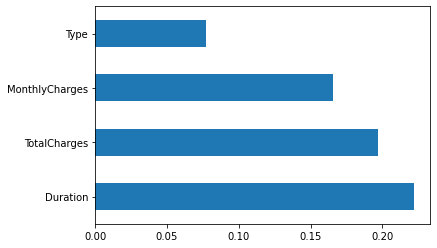

In [80]:
model = RandomForestClassifier()
model.fit(features, target)

(pd.Series(model.feature_importances_, index=features.columns)
   .nlargest(4)
   .plot(kind='barh'))

In [81]:
# перебираю варианты параметров случайного леса
best_auc_roc = 0
best_depth = 0
for depth in range(1, 21, 1):
    forest = RandomForestClassifier(n_estimators=40,
                                   max_depth=depth,
                                   random_state=42,
                                   class_weight='balanced')
    forest.fit(features_train, target_train)
    forest_pred = forest.predict(features_test)
    auc_roc = roc_auc_score(target_test, forest_pred)
    accuracy = accuracy_score(target_test, forest_pred)
    recall = recall_score(target_test, forest_pred)
    precision = precision_score(target_test, forest_pred)
    print('max_depth =', depth, 
          'auc_roc_score =', auc_roc, 
          'accuracy =', accuracy, 
          'recall = ', recall, 
          'precision =', precision)
    if auc_roc > best_auc_roc:
        best_auc_roc = auc_roc
        best_depth = depth
print()
print('best_depth =', best_depth, 'best auc_roc =', best_auc_roc)

max_depth = 1 auc_roc_score = 0.749245209891903 accuracy = 0.7262918796138558 recall =  0.7995824634655533 precision = 0.4980494148244473
max_depth = 2 auc_roc_score = 0.759970231794658 accuracy = 0.7257240204429302 recall =  0.8350730688935282 precision = 0.4975124378109453
max_depth = 3 auc_roc_score = 0.7812028765075446 accuracy = 0.7461669505962522 recall =  0.8580375782881002 precision = 0.520253164556962
max_depth = 4 auc_roc_score = 0.7874203277108119 accuracy = 0.760931289040318 recall =  0.8455114822546973 precision = 0.538563829787234
max_depth = 5 auc_roc_score = 0.7869961145001124 accuracy = 0.7688813174332766 recall =  0.826722338204593 precision = 0.55
max_depth = 6 auc_roc_score = 0.7936377789140794 accuracy = 0.7756956274843839 recall =  0.8329853862212944 precision = 0.5588235294117647
max_depth = 7 auc_roc_score = 0.7985817762564364 accuracy = 0.7819420783645656 recall =  0.8350730688935282 precision = 0.5673758865248227
max_depth = 8 auc_roc_score = 0.792146925960545

In [82]:
# теперь при наилучшей глубине выберем наилучшее количество деревьев
best_auc_roc = 0
best_accuracy = 0
best_est = 0
for est in range(10, 201, 10):
    forest = RandomForestClassifier(n_estimators=est,
                                   max_depth=best_depth,
                                   random_state=42, 
                                   class_weight = 'balanced')
    forest.fit(features_train, target_train)
    forest_pred = forest.predict(features_test)
    auc_roc = roc_auc_score(target_test, forest_pred)
    accuracy = accuracy_score(target_test, forest_pred)
    recall = recall_score(target_test, forest_pred)
    precision = precision_score(target_test, forest_pred)
    print('est =', est, 
          'auc_roc_score =', auc_roc, 
          'accuracy =', accuracy, 
          'recall = ', recall, 
          'precision =', precision)
    if auc_roc > best_auc_roc:
        best_auc_roc = auc_roc
        best_est = est
    if accuracy > best_accuracy:
        best_accuracy = accuracy
print()
print('best_est =', best_est, 'best auc_roc =', best_auc_roc, 'best accuracy =', best_accuracy)

est = 10 auc_roc_score = 0.7982031598591709 accuracy = 0.778534923339012 recall =  0.8413361169102297 precision = 0.5620641562064156
est = 20 auc_roc_score = 0.7923301274430936 accuracy = 0.7756956274843839 recall =  0.8288100208768268 precision = 0.5591549295774648
est = 30 auc_roc_score = 0.7947964265125929 accuracy = 0.7802385008517888 recall =  0.826722338204593 precision = 0.5657142857142857
est = 40 auc_roc_score = 0.7985817762564364 accuracy = 0.7819420783645656 recall =  0.8350730688935282 precision = 0.5673758865248227
est = 50 auc_roc_score = 0.7925825383746039 accuracy = 0.7779670641680864 recall =  0.824634655532359 precision = 0.5626780626780626
est = 60 auc_roc_score = 0.7940163953113448 accuracy = 0.7791027825099376 recall =  0.826722338204593 precision = 0.5641025641025641
est = 70 auc_roc_score = 0.7921925227739799 accuracy = 0.7773992049971608 recall =  0.824634655532359 precision = 0.561877667140825
est = 80 auc_roc_score = 0.7934887750416072 accuracy = 0.78023850085

In [83]:
rocauc = roc_auc_score(target_test, forest.predict(features_test))
rocauc_0 = roc_auc_score(target_test, forest.predict_proba(features_test)[:,0])
rocauc_1 = roc_auc_score(target_test, forest.predict_proba(features_test)[:,1])
print('roc_auc', rocauc,rocauc_0,rocauc_1)

roc_auc 0.7907472666338805 0.12587407462895595 0.874125925371044


In [84]:
forest = RandomForestClassifier(n_estimators=best_est,
                                   max_depth=best_depth,
                                   random_state=42, 
                                   class_weight = 'balanced')

forest_auc_roc_scores = cross_val_score(forest,
                                        features_test,
                                        target_test,
                                        scoring='roc_auc',
                                        cv=3)
print('forest_auc_roc_scores',forest_auc_roc_scores.mean()) 
print()

forest_accuracy_scores = cross_val_score(forest,
                                        features_test,
                                        target_test,
                                        scoring='accuracy',
                                        cv=3)
print('forest_accuracy_scores',forest_accuracy_scores.mean()) 
print()

forest_recall_scores = cross_val_score(forest,
                                        features_test,
                                        target_test,
                                        scoring='recall',
                                        cv=3)
print('forest_recall_scores',forest_recall_scores.mean()) 
print()

forest_presicion_scores = cross_val_score(forest,
                                        features_test,
                                        target_test,
                                        scoring='precision',
                                        cv=3)
print('forest_presicion_scores',forest_presicion_scores.mean()) 
print() 

forest_auc_roc_scores 0.8601766159853973

forest_accuracy_scores 0.7932992617830777

forest_recall_scores 0.7535770440251572

forest_presicion_scores 0.5955468955843833



### Дерево решений

In [85]:
# перебираю варианты параметров дерева решений
best_auc_roc = 0
best_depth = 0
for depth in range(1, 20, 1):
    tree = DecisionTreeClassifier(max_depth=depth,
                                  random_state=42,
                                  class_weight='balanced')
    tree.fit(features_train, target_train)
    tree_pred = tree.predict(features_test)
    auc_roc = roc_auc_score(target_test, tree_pred)
    accuracy = accuracy_score(target_test, tree_pred)
    recall = recall_score(target_test, tree_pred)
    precision = precision_score(target_test, tree_pred)
    print('max_depth =', depth, 
          'auc_roc_score =', auc_roc, 
          'accuracy =', accuracy, 
          'recall = ', recall, 
          'precision =', precision)
    if auc_roc > best_auc_roc:
        best_auc_roc = auc_roc
        best_depth = depth
    if accuracy > best_accuracy:
        best_accuracy = accuracy
print()
print('best_depth =', best_depth, 'best auc_roc =', best_auc_roc, 'best accuracy =', best_accuracy, 'recall = ', recall, 'precision = ', precision)

max_depth = 1 auc_roc_score = 0.7335631629858096 accuracy = 0.6587166382737081 recall =  0.8977035490605428 precision = 0.4378818737270876
max_depth = 2 auc_roc_score = 0.7335631629858096 accuracy = 0.6587166382737081 recall =  0.8977035490605428 precision = 0.4378818737270876
max_depth = 3 auc_roc_score = 0.7516781255801381 accuracy = 0.7717206132879046 recall =  0.7077244258872651 precision = 0.5640599001663894
max_depth = 4 auc_roc_score = 0.7703060523256003 accuracy = 0.7569562748438388 recall =  0.7995824634655533 precision = 0.5356643356643357
max_depth = 5 auc_roc_score = 0.7810774852706007 accuracy = 0.7773992049971608 recall =  0.7891440501043842 precision = 0.5650224215246636
max_depth = 6 auc_roc_score = 0.7719231107448891 accuracy = 0.7450312322544009 recall =  0.8308977035490606 precision = 0.5195822454308094
max_depth = 7 auc_roc_score = 0.7752614488713159 accuracy = 0.7603634298693924 recall =  0.8079331941544885 precision = 0.5397489539748954
max_depth = 8 auc_roc_score

In [86]:
rocauc = roc_auc_score(target_test, tree.predict(features_test))
rocauc_0 = roc_auc_score(target_test, tree.predict_proba(features_test)[:,0])
rocauc_1 = roc_auc_score(target_test, tree.predict_proba(features_test)[:,1])
print('roc_auc', rocauc,rocauc_0,rocauc_1)

roc_auc 0.6982362175489107 0.2993080683561372 0.7006911174150514


In [87]:
tree = DecisionTreeClassifier(max_depth=best_depth,
                                  random_state=42,
                                  class_weight='balanced')

tree_auc_roc_scores = cross_val_score(tree,
                         features_test,
                         target_test,
                         scoring='roc_auc',
                         cv=3)
print('tree_auc_roc_scores', tree_auc_roc_scores.mean())
print()

tree_accuracy_scores = cross_val_score(tree,
                         features_test,
                         target_test,
                         scoring='accuracy',
                         cv=3)
print('tree_accuracy_scores', tree_accuracy_scores.mean())
print()

tree_recall_scores = cross_val_score(tree,
                         features_test,
                         target_test,
                         scoring='recall',
                         cv=3)
print('tree_recall_scores', tree_recall_scores.mean())
print()

tree_precision_scores = cross_val_score(tree,
                         features_test,
                         target_test,
                         scoring='precision',
                         cv=3)
print('tree_precision_scores', tree_precision_scores.mean())
print()

tree_auc_roc_scores 0.8252726033067975

tree_accuracy_scores 0.7279954571266325

tree_recall_scores 0.7974318658280923

tree_precision_scores 0.5005189369317413



### Градиентный бустинг catboost

In [88]:
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=1, depth=2)

catboost_aur_roc_scores = cross_val_score(catboost_model,
                         features_test,
                         target_test,
                         scoring='roc_auc',
                         cv=3)


catboost_accuracy_scores = cross_val_score(catboost_model,
                         features_test,
                         target_test,
                         scoring='accuracy',
                         cv=3)


catboost_recall_scores = cross_val_score(catboost_model,
                         features_test,
                         target_test,
                         scoring='recall',
                         cv=3)


catboost_precision_scores = cross_val_score(catboost_model,
                         features_test,
                         target_test,
                         scoring='precision',
                         cv=3)

print('catboost_aur_roc_scores', catboost_aur_roc_scores.mean())
print('catboost_accuracy_scores', catboost_accuracy_scores.mean())
print('catboost_recall_scores', catboost_recall_scores.mean())
print('catboost_precision_scores', catboost_precision_scores.mean())

0:	learn: 0.4693206	total: 57.3ms	remaining: 57.3s
1:	learn: 0.4280777	total: 58ms	remaining: 28.9s
2:	learn: 0.4134933	total: 58.4ms	remaining: 19.4s
3:	learn: 0.4093782	total: 58.8ms	remaining: 14.6s
4:	learn: 0.4024098	total: 59.2ms	remaining: 11.8s
5:	learn: 0.3982232	total: 59.7ms	remaining: 9.88s
6:	learn: 0.3782933	total: 60.2ms	remaining: 8.53s
7:	learn: 0.3751606	total: 60.6ms	remaining: 7.51s
8:	learn: 0.3670060	total: 61ms	remaining: 6.71s
9:	learn: 0.3637267	total: 61.4ms	remaining: 6.08s
10:	learn: 0.3587293	total: 61.8ms	remaining: 5.55s
11:	learn: 0.3527741	total: 62.2ms	remaining: 5.12s
12:	learn: 0.3492032	total: 62.7ms	remaining: 4.76s
13:	learn: 0.3467507	total: 63ms	remaining: 4.44s
14:	learn: 0.3449450	total: 63.4ms	remaining: 4.16s
15:	learn: 0.3431869	total: 63.8ms	remaining: 3.92s
16:	learn: 0.3403850	total: 64.1ms	remaining: 3.71s
17:	learn: 0.3375723	total: 64.5ms	remaining: 3.52s
18:	learn: 0.3360670	total: 64.9ms	remaining: 3.35s
19:	learn: 0.3336958	total: 

In [89]:
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=1, depth=2)
catboost_model.fit(features_train, target_train)
catboost_pred = catboost_model.predict(features_test)
catboost_auc_roc = roc_auc_score(target_test, catboost_pred)
catboost_accuracy = accuracy_score(target_test, catboost_pred)
catboost_recall = recall_score(target_test, catboost_pred)
catboost_precision = precision_score(target_test, catboost_pred)
print('catboost_auc_roc = ', catboost_auc_roc,
      'catboost_accuracy = ', catboost_accuracy,
      'catboost_recall = ', catboost_recall,
      'catboost_precision =', catboost_precision)

0:	learn: 0.4708459	total: 967us	remaining: 967ms
1:	learn: 0.4422642	total: 1.79ms	remaining: 895ms
2:	learn: 0.4299849	total: 2.7ms	remaining: 899ms
3:	learn: 0.4205519	total: 3.48ms	remaining: 867ms
4:	learn: 0.4135194	total: 4.28ms	remaining: 851ms
5:	learn: 0.4118425	total: 5.2ms	remaining: 862ms
6:	learn: 0.4083327	total: 6.15ms	remaining: 873ms
7:	learn: 0.4017461	total: 7.14ms	remaining: 886ms
8:	learn: 0.3977704	total: 8.16ms	remaining: 898ms
9:	learn: 0.3937470	total: 9.28ms	remaining: 919ms
10:	learn: 0.3898369	total: 10.2ms	remaining: 920ms
11:	learn: 0.3874646	total: 11.3ms	remaining: 929ms
12:	learn: 0.3830217	total: 12.4ms	remaining: 943ms
13:	learn: 0.3813665	total: 13.3ms	remaining: 938ms
14:	learn: 0.3774954	total: 14.5ms	remaining: 952ms
15:	learn: 0.3764409	total: 16.5ms	remaining: 1.01s
16:	learn: 0.3721773	total: 17.9ms	remaining: 1.03s
17:	learn: 0.3711466	total: 18.7ms	remaining: 1.02s
18:	learn: 0.3700512	total: 19.7ms	remaining: 1.01s
19:	learn: 0.3681684	tota

In [90]:
rocauc = roc_auc_score(target_test, catboost_model.predict(features_test))
rocauc_0 = roc_auc_score(target_test, catboost_model.predict_proba(features_test)[:,0])
rocauc_1 = roc_auc_score(target_test, catboost_model.predict_proba(features_test)[:,1])
print('roc_auc', rocauc,rocauc_0,rocauc_1)

roc_auc 0.8432739814811799 0.06631649399587675 0.9336835060041233


## "Эксперименты"

Для увеличения результата метрик пробую удалить менее важные признаки, для проверки важности добавлю шумов

In [91]:
# попробую добавить шумы и проверить важность признаков
# Функции, которые в дальнейшем понадобятся
def plot_features_scores(model, data, target, column_names, model_type):
#  Функция для визуализации важности признаков
    
    model.fit(data, target)
    
    if model_type == 'rf':
        (pd.DataFrame(data={'score': model['rf'].feature_importances_}, 
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False));
    elif model_type == 'lr':
        (pd.DataFrame(data={'score': model['lr'].coef_[0]},
                      index=column_names).sort_values(by='score')
                                         .plot(kind='barh', grid=True,
                                               figsize=(6,6), legend=False));
        
    else:
        raise KeyError('Unknown model_type')

def grid_search(model, gs_params):
#     Функция для подбора гиперпараметров с помощью перекрёстной проверки
     
    gs = GridSearchCV(estimator=model, param_grid=gs_params, refit=True,
                      scoring='roc_auc', n_jobs=-1, cv=skf, verbose=0)
    gs.fit(features, target)
    scores = [gs.cv_results_[f'split{i}_test_score'][gs.best_index_] for i in range(5)]
    print('scores = {}, \nmean score = {:.5f} +/- {:.5f} \
           \nbest params = {}'.format(scores,
                                      gs.cv_results_['mean_test_score'][gs.best_index_],
                                      gs.cv_results_['std_test_score'][gs.best_index_],
                                      gs.best_params_))
    return gs

#### Случайный лес

scores = [0.85928466 0.84335684 0.86247255 0.8318452  0.84719536] 
mean score = 0.84883 +/- 0.01110


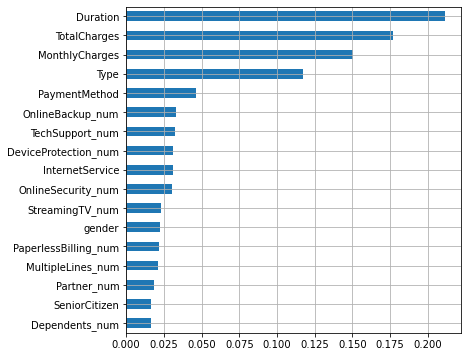

In [92]:
rf = Pipeline([('rf', RandomForestClassifier(n_jobs=-1, 
                                             class_weight='balanced', 
                                             random_state=42))])

# параметры кросс-валидации (стратифицированная 5-фолдовая с перемешиванием) 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(estimator=rf, X=features, y=target, 
                         cv=skf, scoring='roc_auc', n_jobs=-1)
print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

# важность признаков
plot_features_scores(model=rf, data=features, target=target, column_names=features.columns, model_type='rf')

#### Логистическая Регрессия

scores = [0.85297089 0.83854917 0.85454287 0.8219075  0.82619674] 
mean score = 0.83883 +/- 0.01336


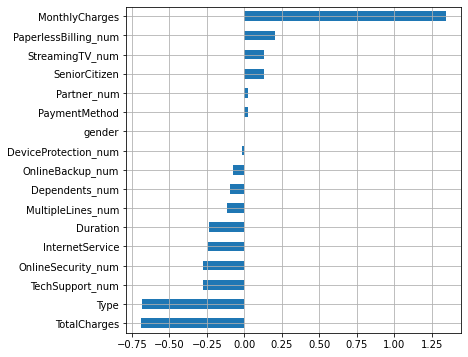

In [93]:
lr = Pipeline([('p_trans', PowerTransformer(method='yeo-johnson', standardize=True)),
               ('lr', LogisticRegression(solver='liblinear',
                                         penalty='l1',
                                         max_iter=200,
                                         class_weight='balanced',
                                         random_state=42)
               )])
scores = cross_val_score(estimator=lr, X=features, y=target, 
                         cv=skf, scoring='roc_auc', n_jobs=-1)
print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

plot_features_scores(model=lr, data=features, target=target, column_names=features.columns, model_type='lr')


#### Добавление шумов

,gender,Type,PaymentMethod,InternetService,SeniorCitizen,MonthlyCharges,TotalCharges,Partner_num,Dependents_num,PaperlessBilling_num,...,lapl_0,norm_1,unif_1,lapl_1,norm_2,unif_2,lapl_2,norm_3,unif_3,lapl_3
0,0.0,0.0,2.0,0.0,0,29.85,29.85,1,0,1,...,19.313380,6.455487,4.185253,-1.425035,5.399718,3.873206,5.481185,4.580322,3.440012,-19.065551
1,1.0,1.0,3.0,0.0,0,56.95,1889.50,0,0,0,...,-2.683431,6.905199,4.286975,1.691112,1.256220,3.605155,2.168858,6.269044,4.161494,-7.176344
2,1.0,0.0,3.0,0.0,0,53.85,108.15,0,0,1,...,4.020947,5.996590,4.550739,9.227005,4.789390,5.241756,5.013144,3.431685,7.667440,9.053771
3,1.0,1.0,0.0,0.0,0,42.30,1840.75,0,0,0,...,0.396605,1.655250,2.564950,-6.679492,3.935057,4.088604,5.842627,3.747225,8.112069,0.501075
4,0.0,0.0,2.0,1.0,0,70.70,151.65,0,0,1,...,1.467925,3.768731,4.111108,3.072811,2.269137,4.708052,-8.955175,3.980140,8.232886,2.131368


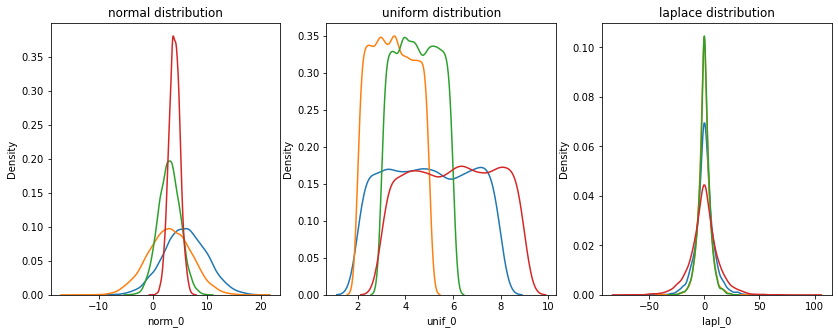

In [94]:
F = features
np.random.seed(42)

fix, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(14,5))
ax1.set_title("normal distribution")
ax2.set_title("uniform distribution")
ax3.set_title("laplace distribution")
for i in range(4):
    F.loc[:, f'norm_{i}'] = np.random.normal(loc=np.random.randint(low=0, high=10), 
                                             scale=np.random.randint(low=1, high=10), 
                                             size=(F.shape[0], 1))
    
    F.loc[:, f'unif_{i}'] = np.random.uniform(low=np.random.randint(low=1, high=4), 
                                              high=np.random.randint(low=5, high=10), 
                                              size=(F.shape[0], 1))
    F.loc[:, f'lapl_{i}'] = np.random.laplace(loc=np.random.randint(low=0, high=10), 
                                              scale=np.random.randint(low=1, high=10), 
                                              size=(F.shape[0], 1))
    # визуализирукем распределения признаков
    sns.kdeplot(F[f'norm_{i}'], ax=ax1)
    sns.kdeplot(F[f'unif_{i}'], ax=ax2)
    sns.kdeplot(F[f'lapl_{i}'], ax=ax3)

# итоговый датасет
F.head()

scores = [0.86536464 0.85130331 0.86587357 0.83555322 0.84514734] 
mean score = 0.85265 +/- 0.01172


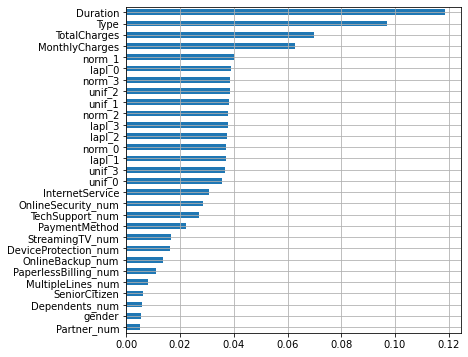

In [95]:
scores = cross_val_score(estimator=rf, X=F, y=target, 
                         cv=skf, scoring='roc_auc', n_jobs=-1)
print('scores = {} \nmean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))
plot_features_scores(model=rf, data=F, target=target, column_names=F.columns, model_type='rf')

### Новый датафрейм без слабо влияющих признаков
Видим, что некоторые признаки из исходного датасета влияют на модель слабее искусственных шумов.

In [96]:
df_new = df_ord[['Duration', 'Type', 'TotalCharges', 'MonthlyCharges', 'Target']]

features_new = df_new.drop('Target', axis=1)
target_new = df_new['Target']

df_new_train, df_new_test = train_test_split(df_new, test_size=0.25, random_state=42)

print(df_new_train.shape)
print(df_new_test.shape)
print()

features_new_train = df_new_train.drop('Target', axis=1)
target_new_train = df_new_train['Target']

features_new_test = df_new_test.drop('Target', axis=1)
target_new_test = df_new_test['Target']

print(features_new_train.shape)
print(target_new_train.shape)

print()

print(features_new_test.shape)
print(target_new_test.shape)

(5282, 5)
(1761, 5)

(5282, 4)
(5282,)

(1761, 4)
(1761,)


#### Проверка логистической регресии

In [112]:
lr = LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')
lr.fit(features_new_train, target_new_train)
lr_new_pred = lr.predict(features_new_test)
lr_new_auc_roc = roc_auc_score(target_new_test, lr_new_pred)
lr_new_accuracy = accuracy_score(target_new_test, lr_new_pred)
lr_new_recall = recall_score(target_new_test, lr_new_pred)
lr_new_precision = precision_score(target_new_test, lr_new_pred)
print('lr_new_auc_roc =', lr_new_auc_roc)
print('lr_new_accuracy =', lr_new_accuracy)
print('lr_new_recall =', lr_new_recall)
print('lr_new_precision =', lr_new_precision)

lr_new_auc_roc = 0.7649712251538078
lr_new_accuracy = 0.7177739920499716
lr_new_recall = 0.8684759916492694
lr_new_precision = 0.4894117647058824


In [114]:
rocauc = roc_auc_score(target_new_test, lr.predict(features_new_test))
rocauc_0 = roc_auc_score(target_new_test, lr.predict_proba(features_new_test)[:,0])
rocauc_1 = roc_auc_score(target_new_test, lr.predict_proba(features_new_test)[:,1])
print('roc_auc', rocauc,rocauc_0,rocauc_1)

roc_auc 0.7649712251538078 0.15605509397828943 0.8439449060217106


In [108]:
lr_new_auc_roc_scores = cross_val_score(lr,
                         features_new_test,
                         target_new_test,
                         scoring='roc_auc',
                         cv=3)
print('lr_new_auc_roc_scores =',lr_new_auc_roc_scores.mean())

lr_new_accuracy_scores = cross_val_score(lr,
                         features_new_test,
                         target_new_test,
                         scoring='accuracy',
                         cv=3)
print('lr_new_accuracy_scores =',lr_new_accuracy_scores.mean())

lr_new_recall_scores = cross_val_score(lr,
                         features_new_test,
                         target_new_test,
                         scoring='recall',
                         cv=3)
print('lr_new_recall_scores =',lr_new_recall_scores.mean())

lr_new_precision_scores = cross_val_score(lr,
                         features_new_test,
                         target_new_test,
                         scoring='precision',
                         cv=3)
print('lr_new_precision_scores =',lr_new_precision_scores.mean())

lr_new_auc_roc_scores = 0.842185294871172
lr_new_accuracy_scores = 0.7308347529812607
lr_new_recall_scores = 0.8391509433962264
lr_new_precision_scores = 0.5039173850646667


#### Проверка случайного леса

In [116]:
forest = RandomForestClassifier(n_estimators=est,
                                max_depth=best_depth,
                                random_state=42, 
                                class_weight = 'balanced')
forest.fit(features_new_train, target_new_train)    
forest_new_pred = forest.predict(features_new_test)
new_auc_roc = roc_auc_score(target_new_test, forest_new_pred)
new_accuracy = accuracy_score(target_new_test, forest_new_pred)
new_recall = recall_score(target_new_test, forest_new_pred)
new_precision = precision_score(target_new_test, forest_new_pred)
print('new_auc_roc_ =', new_auc_roc)
print('new_accuracy = ', new_accuracy)
print('new_recall = ', new_recall)
print('new_precision = ', new_precision)

new_auc_roc_ = 0.7876271418288883
new_accuracy =  0.7745599091425327
new_recall =  0.8162839248434238
new_precision =  0.5585714285714286


In [117]:
rocauc = roc_auc_score(target_new_test, forest.predict(features_new_test))
rocauc_0 = roc_auc_score(target_new_test, forest.predict_proba(features_new_test)[:,0])
rocauc_1 = roc_auc_score(target_new_test, forest.predict_proba(features_new_test)[:,1])
print('roc_auc', rocauc,rocauc_0,rocauc_1)

roc_auc 0.7876271418288883 0.13005188265985754 0.8699481173401424


In [103]:
forest = RandomForestClassifier(n_estimators=best_est,
                                max_depth=best_depth,
                                random_state=42, 
                                class_weight = 'balanced')

forest_exp_auc_roc_scores = cross_val_score(forest,
                         features_new_test,
                         target_new_test,
                         scoring='roc_auc',
                         cv=3)
print('forest_exp_auc_roc_scores =',forest_exp_auc_roc_scores.mean())

forest_exp_accuracy_scores = cross_val_score(forest,
                         features_new_test,
                         target_new_test,
                         scoring='accuracy',
                         cv=3)
print('forest_exp_accuracy_scores =',forest_exp_accuracy_scores.mean())

forest_exp_recall_scores = cross_val_score(forest,
                         features_new_test,
                         target_new_test,
                         scoring='recall',
                         cv=3)
print('forest_exp_recall_scores =',forest_exp_recall_scores.mean())

forest_exp_precision_scores = cross_val_score(forest,
                         features_new_test,
                         target_new_test,
                         scoring='precision',
                         cv=3)
print('forest_exp_precision_scores =',forest_exp_precision_scores.mean())

forest_exp_auc_roc_scores = 0.8550995449225516
forest_exp_accuracy_scores = 0.7620670073821693
forest_exp_recall_scores = 0.7807783018867925
forest_exp_precision_scores = 0.5449423046266662


В обоих случаях с рассмотрением важности признаков результат моделей, пусть и незначительно, но упал. 

Сравню все варианты

## Вывод

In [132]:
lr_auc_roc = 0.7824991287751719
lr_accuracy = .7490062464508802
lr_recall = 0.8559498956158664
lr_precision = 0.5236270753512133
lr_auc_roc_scores = 0.8496634630848715
lr_accuracy_scores = 0.7541169789892107
lr_recall_scores = 0.8371069182389937
lr_precision_scores = 0.5331955090774413
lr_pred_proba_roc_auc = 0.8540502997990482

forest_auc_roc = 0.7985817762564364
forest_accuracy = 0.7819420783645656 
forest_recall = 0.8350730688935282
forest_precision = 0.5673758865248227
forest_auc_roc_scores = 0.8601766159853973
forest_accuracy_scores = 0.7932992617830777
forest_recall_scores = 0.7535770440251572
forest_precision_scores = 0.5955468955843833
forest_pred_proba_roc_auc = 0.874125925371044

tree_auc_roc = 0.7810774852706007 
tree_accuracy = 0.7825099375354913 
tree_recall = 0.5594989561586639 
tree_precision = 0.5618448637316562
tree_scores = 0.8601766159853973
tree_auc_roc_scores = 0.8252726033067975
tree_accuracy_scores = 0.7279954571266325
tree_recall_scores = 0.7974318658280923
tree_precision_scores = 0.5005189369317413
tree_pred_proba_roc_auc = 0.7006911174150514

catboost_auc_roc =  0.8432739814811799 
catboost_accuracy =  0.8869960249858035 
catboost_recall =  0.7473903966597077 
catboost_precision = 0.8211009174311926
catboost_auc_roc_scores = 0.8649857486604012
catboost_accuracy_scores = 0.8137421919363997
catboost_recall_scores = 0.6282363731656185
catboost_precision_scores = 0.6677300723801953
catboost_pred_proba_roc_auc = 0.9340417666811056

lr_exp_auc_roc = 0.7649712251538078
lr_exp_accuracy = 0.7177739920499716
lr_exp_recall = 0.8684759916492694
lr_exp_precision = 0.4894117647058824
lr_exp_auc_roc_scores = 0.842185294871172
lr_exp_accuracy_scores = 0.7308347529812607
lr_exp_recall_scores = 0.8391509433962264
lr_exp_precision_scores = 0.5039173850646667
lr_exp_pred_proba_roc_auc = 0.8439449060217106

forest_exp_auc_roc = 0.7876271418288883
forest_exp_accuracy =  0.7745599091425327
forest_exp_recall =  0.8162839248434238
forest_exp_precision =  0.5585714285714286
forest_exp_auc_roc_scores = 0.8550995449225516
forest_exp_accuracy_scores = 0.7620670073821693
forest_exp_recall_scores = 0.7807783018867925
forest_exp_precision_scores = 0.5449423046266662
forest_exp_pred_proba_roc_auc = 0.8699481173401424

In [135]:
df_dict = {'model': ['tree', 'forest', 'linear', 'catboost', 'lr_exp', 'forest_exp'], 
           'auc_roc_scores': [tree_auc_roc_scores, 
                              forest_auc_roc_scores, 
                              lr_auc_roc_scores, 
                              catboost_auc_roc_scores, 
                              lr_exp_auc_roc_scores, 
                              forest_exp_auc_roc_scores],
           'auc_roc': [tree_auc_roc, 
                       forest_auc_roc, 
                       lr_auc_roc, 
                       catboost_auc_roc, 
                       lr_exp_auc_roc, 
                       forest_exp_auc_roc],
           'accuracy_scores': [tree_accuracy_scores, 
                               forest_accuracy_scores, 
                               lr_accuracy_scores, 
                               catboost_accuracy_scores, 
                               lr_exp_accuracy_scores, 
                               forest_exp_accuracy_scores],
           'accuracy': [tree_accuracy, 
                        forest_accuracy, 
                        lr_accuracy, 
                        catboost_accuracy, 
                        lr_exp_accuracy, 
                        forest_exp_accuracy],
           'recall_scores': [tree_recall_scores, 
                             forest_recall_scores, 
                             lr_recall_scores, 
                             catboost_recall_scores, 
                             lr_exp_recall_scores, 
                             forest_exp_recall_scores],
           'recall': [tree_recall, 
                      forest_recall, 
                      lr_recall, 
                      catboost_recall, 
                      lr_exp_recall, 
                      forest_exp_recall],
           'precision_scores': [tree_precision_scores, 
                                 forest_precision_scores, 
                                 lr_precision_scores, 
                                 catboost_precision_scores, 
                                 lr_exp_precision_scores, 
                                 forest_exp_precision_scores],
           'precision': [tree_precision, 
                        forest_precision, 
                        lr_precision, 
                        catboost_precision, 
                        lr_exp_precision, 
                        forest_exp_precision],
           'roc_auc_pred_proba': [tree_pred_proba_roc_auc, 
                                  forest_pred_proba_roc_auc, 
                                  lr_pred_proba_roc_auc, 
                                  catboost_pred_proba_roc_auc, 
                                  lr_exp_pred_proba_roc_auc, 
                                  forest_exp_pred_proba_roc_auc]
          }
dt = pd.DataFrame(df_dict)
dt = dt.sort_values('roc_auc_pred_proba', ascending=False)
display(dt)

,model,auc_roc_scores,auc_roc,accuracy_scores,accuracy,recall_scores,recall,precision_scores,precision,roc_auc_pred_proba
3,catboost,0.864986,0.843274,0.813742,0.886996,0.628236,0.747390,0.667730,0.821101,0.934042
1,forest,0.860177,0.798582,0.793299,0.781942,0.753577,0.835073,0.595547,0.567376,0.874126
5,forest_exp,0.855100,0.787627,0.762067,0.774560,0.780778,0.816284,0.544942,0.558571,0.869948
2,linear,0.849663,0.782499,0.754117,0.749006,0.837107,0.855950,0.533196,0.523627,0.854050
4,lr_exp,0.842185,0.764971,0.730835,0.717774,0.839151,0.868476,0.503917,0.489412,0.843945
0,tree,0.825273,0.781077,0.727995,0.782510,0.797432,0.559499,0.500519,0.561845,0.700691


**Вывод**

Модель градиентного бустинга CatboostClassifier показывает в практически всех метриках наилучшие результаты. Метрика roc_auc и в обычном обучении с методом predict(), и в кросс-валидации, и в обучении с методом predict_proba() также везде максимальная.

**Модель CatboostClassifier с методом predict_proba().**

**Результат auc_roc = 0.9340417666811056**

## Отчёт по проделанной работе

Вопросы   

    Какие пункты плана были выполнены, а какие — нет (поясните почему)?
    Какие трудности возникли и как вы их преодолели?
    Какие ключевые шаги в решении задачи выделили?
    Какая ваша итоговая модель и какое у неё качество?

### Вопрос 1. 
**Какие пункты плана были выполнены, а какие — нет (поясните почему)?**

**Примерный план решения**

- [x] EDA 
- [x] Выборки: разделю датасет на обучающую, тестовую и валидационную (если это будет не кросс-валидация) 

$\color{green}{\text{(Пункт выполнен, но дополнительно была еще проведена предобработка данных, получены новые признаки:}}$
$\color{green}{\text{продолжительность жизни клиента и целевой признак; закодированы признаки, выраженные строками. }}$
$\color{green}{\text{А также кроме двух выборок [features_train, target_train] и [features_test, target_test] были}}$
$\color{green}{\text{получены отдельно обучающие и целевой признак по всему датасету features и target для кросс-валидации)}}$

- [x] Обучение и подбор параметров: рассмотрю несколько моделей. Так как в задаче поставлени вопрос классификации, то целевым признаком будет ушел клиент или нет, то есть EndData = 'No'. Рассмотрю несколько моделей, метрикой возьму accuracy (?). 

$\color{green}{\text{(Пункт выполнен, но также дополнительно был получен целевой категориальный признак, были рассмотрены}}$
$\color{green}{\text{следущие модели: LogisticRegression, RandomForestClassifier, DecisionTreeClassifier,}}$
$\color{green}{\text{CatBoostClassifier, LGBMClassifier.}}$
$\color{green}{\text{Кроме accuracy были рассмотрены и другие метрики: AUC ROC - основная, recall, precision - дополнительно}}$
$\color{green}{\text{Также дополнительно были проведены эсперименты по проверке важности признаков, с их учетом модели показывали}}$ $\color{green}{\text{результаты хуже, поэтому было принято решение оставить первоначальные предобработанные и закодированные данные.}}$
$\color{green}{\text{Также модель, которая получила наивысший результат на методе predict, на методе predict_proba}}$
$\color{green}{\text{дала результат еще лучше.)}}$

- [ ] Тестирование. Проверю модели с параметрами, дающими лучшие результаты и протестирую их. 

$\color{red}{\text{Тестирование как таковое проводилось в предыдущем пункте}}$

- [x] Выводы 

$\color{green}{\text{В последнем пункте была получена сравнительная таблица и исходя из нее сделан вывод о максимальном результате}}$

### Вопрос 2. 
**Какие трудности возникли и как вы их преодолели?**

Сложности были в подборе параметров для достижения максимального качества каждой модели. Это было самым времязатратным действием. Также была сложность в определении важности признаков, так как было так же потрачено много времени на это, а результат в итоге оказался ниже. Все было преодолено использованием дополнительной информации и предложенных тимлидом на изучение статей.

### Вопрос 3.
**Какие ключевые шаги в решении задачи выделили?**

- [x] Первичное знакомство с данными и их предобработка
- [x] Несмотря на то, что в первой части проекта была проведена предобработка данных перед исследовательским анализом, при обучении потребовалась *еще одна предобработка* именно для эффективной работы моделей. 
- [x] Проверка моделей с учетом экспериментов для достижения наивысшего результата 
- [x] Сравнение результатов

### Вопрос 4.
**Какая ваша итоговая модель и какое у неё качество?**

Модель CatboostClassifier(iterations=1000, learning_rate=1, depth=2) с методом predict_proba().

**Результат auc_roc = 0.9340417666811056**